In [1]:
import numpy as np
import torch 

import matplotlib.pyplot as plt
%matplotlib inline

import torch, torch.nn as nn

import time 
from IPython import  display

# Dataset

In [2]:
def f(x, a, w, b):
    return a[0]*np.sin(w[0]*x+b[0])+a[1]*np.sin(2*w[1]*x+b[1])

In [3]:
def generate_dataset(N, Size=None):
    """N - number of datasets to be generated"""
    param_set = {'w':[], 'a':[], 'b':[], 'mu_x':[]}
    datasets = []
    for i in range(N):
        if Size is None:
            Size = np.random.randint(low=4, high=50)
        w = np.random.uniform(low=5, high=7, size=2)
        b = np.random.uniform(low=0, high=2*np.pi, size=2)
        a = np.random.normal(loc=0, scale=1.0, size=2)
        mu_x = np.random.uniform(low=-4, high=4, size=1)

        param_set['w'].append(w); param_set['b'].append(b); param_set['a'].append(a); param_set['mu_x'].append(mu_x); 
        
        x = np.random.normal(loc=mu_x, scale=1.0, size=Size)
        y = np.random.normal(loc=f(x, a, w, b), scale=0, size=Size)
    
        datasets.append((x, y))
        
    return datasets, param_set

In [4]:
def iterate_minibatches(datasets, batchsize):
    """iterate between datasets with defined batchsize"""
    for ind, d in enumerate(datasets):
        indices = np.random.permutation(np.arange(len(d[0])))
        for start in range(0, len(indices), batchsize):
            ix = indices[start: start + batchsize]
            
            yield  ind, torch.FloatTensor(d[0][ix]).unsqueeze(1), torch.FloatTensor(d[1][ix]).unsqueeze(1), len(d[0])

# Model

In [118]:
class fc_block(nn.Module):
    def __init__(self, dim_in, dim_out):
        
        super(fc_block, self).__init__()
        self.fc = nn.Sequential(nn.Linear(dim_in, dim_out), 
                                nn.LayerNorm(dim_out),
                                nn.ReLU())
                                
    def forward(self, C):

        return self.fc(C) 

class Decoder(nn.Module):
    def __init__(self, in_z, in_x, dim_middle, dim_out, n_layers):
        """ 
        nn that maps from latent space Z and the sample X to the target variable Y
        
        """
        super(Decoder, self).__init__()
        
#         in_z = 0
        self.fc0 = nn.Linear(in_z+in_x, dim_middle) 
        self.fc1 = fc_block(dim_middle, dim_middle)
                
        self.layer_stack = nn.ModuleList([
            fc_block(dim_middle, dim_middle)
            for _ in range(n_layers)])
        
        self.fc_last_mu = nn.Linear(dim_middle, dim_out)
        self.fc_last_sigma = nn.Linear(dim_middle, dim_out)

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    
 
    def forward(self, X, z):
        """
        takes x and latent z and produces target y
        """
  
        c = torch.cat([X, z], dim=-1)
#         c = X
        if verbose: print('c', c.shape)
        c = self.relu(self.fc0(c))
    
        c, c_prev = self.fc1(c), c
        if verbose: print('c', c.shape)

        for fc in self.layer_stack:
            c, c_prev = fc(c+c_prev), c

        if verbose: print('c', c.shape)
            
        self.mu_y = self.fc_last_mu(c)
        self.sigma_y = self.sigmoid(self.fc_last_sigma(c))*0.1+0.001


        return self.mu_y, self.sigma_y
    


In [119]:
class Encoder(nn.Module):
    def __init__(self, dim_in, dim_middle, dim_out, n_layers):
        """ 
        nn that maps dataset to the latent z that represent it      
        """
        super(Encoder, self).__init__()
        
        # пока самая простая 
        self.fc1 = nn.Linear(dim_in, dim_middle)
        self.relu = nn.ReLU()
        
        self.layer_stack = nn.ModuleList([
            fc_block(dim_middle, dim_middle)
            for _ in range(n_layers)])
            
        self.fc_last_mu = nn.Linear(dim_middle, dim_out)
        self.fc_last_sigma = nn.Linear(dim_middle, dim_out)
        
 
    def forward(self, S):
        """
        takes dataset S and produces mu and sigma of normal distribution z
        """

        S = self.relu(self.fc1(S))  
        S_prev = S
        
        for fc in self.layer_stack:
            S, S_prev = fc(S+S_prev), S
            
        if verbose: print('S', S.shape)
        S = S.mean(0)
        
        self.mu_z = self.fc_last_mu(S)
        self.sigma_z = (self.fc_last_sigma(S)-10).exp() # экспонента чтобы не было отрицательных значений дисперсии

        return self.mu_z, self.sigma_z
    


$$\ln p(D) \ge \sum_j E_{N(z | 0, 1)} \sum_i \ln p(y_{ij} | x_{ij}, h_\alpha(\mu_z+\Sigma_z^{1/2} z)) - \sum_j KL(q_{\theta_j}(z_j, S_j) || p(z_j)) $$

${KL({\mathcal {N}}_{0}\|{\mathcal {N}}_{1})={1 \over 2}\left\{\operatorname {tr} \left({\boldsymbol {\Sigma }}_{1}^{-1}{\boldsymbol {\Sigma }}_{0}\right)+\left({\boldsymbol {\mu }}_{1}-{\boldsymbol {\mu }}_{0}\right)^{\rm {T}}{\boldsymbol {\Sigma }}_{1}^{-1}({\boldsymbol {\mu }}_{1}-{\boldsymbol {\mu }}_{0})-k+\ln {|{\boldsymbol {\Sigma }}_{1}| \over |{\boldsymbol {\Sigma }}_{0}|}\right\},}$

$$\Sigma_0 = \Sigma_z \\ 
\mu_0 = \mu_z, \\ 
\Sigma_1 = I, \\ 
\mu_1 = 0$$

$$KL(q_{\theta_j}(z_j, S_j) || p(z_j))= \frac 1 2 ( \sum_i \sigma_i + \mu_z^T\mu_z - 2D -\sum_i\ln{\sigma_i}) $$


In [120]:
class DeepPrior(nn.Module):
    def __init__(self, in_x, in_z, dim_middle, dim_out, n_enc_layers, n_dec_layers):
        
        super(DeepPrior, self).__init__()
    
        self.dim_z = in_z
        
        in_y = 1
        self.in_z = in_z
        
        self.encoder = Encoder(in_x+in_y, dim_middle, self.in_z, n_enc_layers)
        self.decoder = Decoder(in_z, in_x, dim_middle, dim_out, n_dec_layers)
        
        self.ELBO = {}
 
    def forward(self, ind, X, y, l):
        """
        takes dataset S and produces ELBO lower bound for p(D) where D - dataset
        """
        
        # now let compute stohastic part
        S = torch.cat([X, y], dim = -1)
        if verbose: print('S', S.shape)
        mu_z, sigma_z = self.encoder(S)
        if verbose: print('mu_z, sigma_z', mu_z.shape, sigma_z.shape)
        sigma_z = sigma_z.pow(1/2)
   
        # firstly let compute not stochastic component that corresponds to KL term
        KL_part = -1/2 * (sigma_z.sum()+(mu_z*mu_z).sum() - 2*self.dim_z - sigma_z.log().sum())
        
        if verbose: print('KL_part', KL_part)
            
        #sampling
        N_batch = S.shape[0]
        z = torch.normal(mean = torch.zeros((1, self.in_z)), 
                          std = torch.ones((1,  self.in_z)))
        
        z = z.repeat(N_batch, 1)
        
        if verbose: print('z', z.shape)
            
        z = mu_z+sigma_z*z
        if verbose: print('z', z.shape)
        mu_y, sigma_y = self.decoder(X, z)
        
        if verbose: print('mu_y, sigma_y', mu_y.shape, sigma_y.shape)
        
        
        log_likelihood = -1/2*(y - mu_y)*(y-mu_y)/ sigma_y.pow(2)
        if verbose: print('log_likelihood', log_likelihood.shape) 
            
        log_likelihood = log_likelihood.sum()-sigma_y.log().sum()
        if verbose: print('log_likelihood', log_likelihood.shape)

        ratio = float(np.max([l/N_batch, 1]))
        loss = ratio*log_likelihood+KL_part
        
        l_np = float(loss.cpu().data.numpy())
#         print('l_np',l_np)
        try:
            self.ELBO[ind].append(l_np)
        except KeyError:
            self.ELBO[ind]=[l_np]

        
        return -loss
    
    def predict(self, X, y, X_pred):
        """
        S - dataset (tuple with two tensors with shape (Points, 1))
        X - points to predict y in (tensor with shape (N_points, ))
        """
        
        S = torch.cat([X, y], dim = -1)
        if verbose: print('S', S.shape)
        mu_z, sigma_z = self.encoder(S)
        
#         sigma_z = sigma_z.pow(1/2)
#         N_batch = 1
#         z = torch.normal(mean = torch.zeros((N_batch, self.in_z)), 
#                           std = torch.ones((N_batch,  self.in_z)))      
#         if verbose: print('z', z.shape)
            
        z = mu_z.unsqueeze(0) #+sigma_z*z
        if verbose: print('z', z.shape)
            
        z = z.repeat(X_pred.shape[0], 1)
        if verbose: 
            print('z', z.shape)
            print('X', X.shape)
            
        mu_y, sigma_y = self.decoder(X_pred, z)
        
        return mu_y, sigma_y

        

# Training

In [139]:
def train_model(num_epochs=20, batchsize = 10, verbose=True, plot_every = 100):
    
    num_epochs = num_epochs # total amount of full passes over training data
    

    for epoch in range(num_epochs):
        if verbose and epoch % plot_every == 0: start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        for (ind, X_batch, y_batch, l) in iterate_minibatches(datasets, batchsize):
            
#             print('ind', ind)
            loss = model(ind, torch.Tensor(X_batch), torch.Tensor(y_batch), l)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            if ind==0:
                X_0 = X_batch
                y_0 = y_batch


        # Visualize
        # Then we print the results for this epoch:
        if verbose and epoch % plot_every == 0:

            display.clear_output(wait=True)
            print("Epoch {} of {} took {:.3f}s".format(
                epoch + 1, num_epochs, time.time() - start_time)) 

            ELBO = np.array(list(model.ELBO.values()))
            print('current elbo: {}'.format(ELBO[0][-1]))

            plot_f(param_set, (X_0.data.numpy().flatten(), y_0.data.numpy().flatten()))

            plt.figure(figsize=(16, 6))
            plt.subplot(221)
            plt.title("ELBO")
            plt.xlabel("#iteration")
            plt.ylabel("elbo")
            plt.plot(ELBO.T, label = 'train_elbo')
            plt.show()
           
    return X_0, y_0

In [140]:
# оптимайзер
from torch import optim
from itertools import chain
model = DeepPrior(in_x=1, in_z=128, dim_middle=128, dim_out=1, n_enc_layers=4, n_dec_layers=4)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [141]:
def plot_f(params, dataset, num_points=1000):
    """
    params - true function that we approximate
    dataset - points that we observe to utilize for prediction
    """
    
    X = np.linspace(start=-6, stop=6, num=num_points)
    y = f(X, params['a'][0], params['w'][0], params['b'][0])
    
    plt.figure(figsize=(16, 6))
    plt.title("Approximation")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.plot(X, y)
    
    plt.plot(dataset[0], dataset[1], 'o')
    
    y_pred, sigma_pred = model.predict(torch.FloatTensor(dataset[0]).unsqueeze(1), 
                                       torch.FloatTensor(dataset[1]).unsqueeze(1), 
                                       torch.FloatTensor(X).unsqueeze(1))
    y_pred = y_pred.data.numpy().flatten()
    sigma_pred = sigma_pred.data.numpy().flatten()
    
    plt.fill_between(X, y_pred-2*sigma_pred, y_pred+2*sigma_pred, alpha = 0.4, label = '2 sigma', color='red')
    
    plt.plot(X, y_pred)  
    plt.show()

In [142]:
datasets, param_set = generate_dataset(50, Size=50)

In [143]:
# # liner dataset
# X = np.linspace(start=-6, stop=6, num=50)

# def R(x, a, b):
#     return a*x+b
    
# y = R(X, 0.5, 2)

# datasets = []
# datasets.append((X, y))

Epoch 9901 of 10000 took 0.473s
current elbo: -2116.681396484375


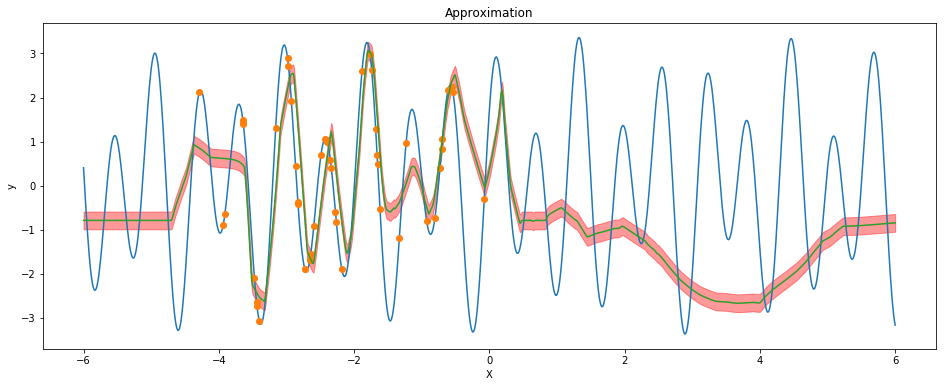

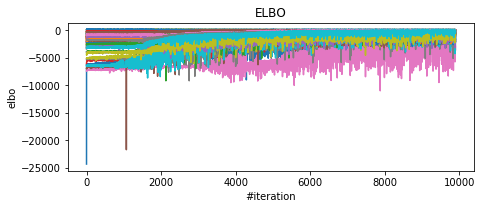

In [144]:
verbose = False
X_0, y_0 = train_model(num_epochs=10000, batchsize = 50)

In [145]:
# plot_f(param_set, (X_0.data.numpy().flatten(), y_0.data.numpy().flatten()))

In [146]:
test_set, test_param = generate_dataset(1, Size=20)

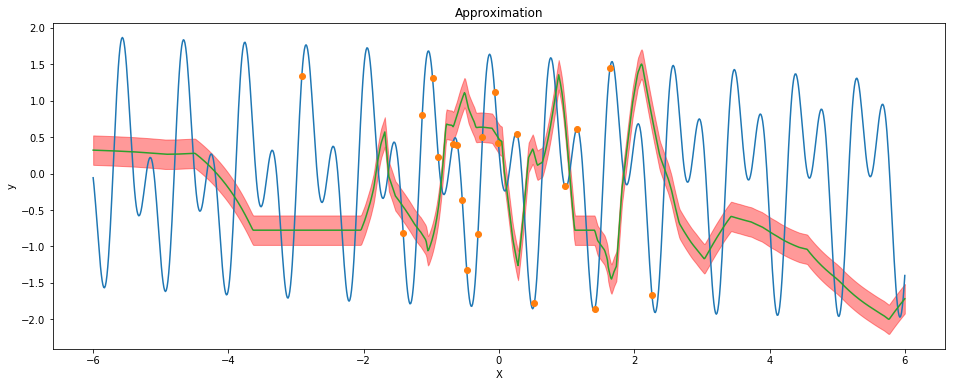

In [147]:
verbose = False
plot_f(test_param, test_set[0])